In [3]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### These first few lines of code import all the python modules/packages that are needed for later use.

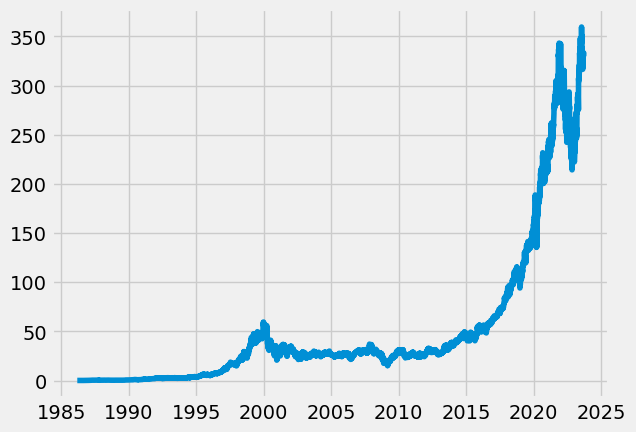

In [6]:
df = pd.read_csv("MSFT.csv")
df = df[['Date', 'Close']]
df['Date']

import datetime
def str_to_datetime(s): 
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
datetime_object = str_to_datetime('1986-03-19')
datetime_object

df['Date'] = df['Date'].apply(str_to_datetime) 
df['Date']
df.index = df.pop('Date')
df
plt.plot(df.index, df['Close'])

### This model is based on the data for Microsoft. I  have access and downloaded the data from  historical data section on Yahoo Finance.The first three lines of code here download the data and reframe the data frame. The data type for attribute “Date” is shown as object by printing the data frame out. The next few lines of code develop a function for converting the data type for attribute “Date” from object to datetime64 which is what our model needs

### Now conversion into Supervised Learning 

In [7]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day first time: '1986-03-18'
# Start day second time around: '2022-09-12'
windowed_df = df_to_windowed_df(df,
                                '2022-09-12',
                                '2023-09-08',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-09-12,258.089996,258.519989,264.459991,266.649994
1,2022-09-13,258.519989,264.459991,266.649994,251.990005
2,2022-09-14,264.459991,266.649994,251.990005,252.220001
3,2022-09-15,266.649994,251.990005,252.220001,245.380005
4,2022-09-16,251.990005,252.220001,245.380005,244.740005
...,...,...,...,...,...
245,2023-09-01,328.410004,328.790009,327.760010,328.660004
246,2023-09-05,328.790009,327.760010,328.660004,333.549988
247,2023-09-06,327.760010,328.660004,333.549988,332.880005
248,2023-09-07,328.660004,333.549988,332.880005,329.910004


### Since this is an LSTM model, it’s necessary to convert the problem into a supervise learning problem. The above mentioned  codes here convert the date into getting its three previous days values (Target-3, Target-2 and Target-1). Think in a way like  “Target-3, Target-2 and Target-1” as the input and Target as the output for the prediction.




### Now conversion into Numpy Array 

In [8]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy() 

  dates = df_as_np[:, 0] 

  middle_matrix = df_as_np[:, 1:-1] 
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) 
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((250,), (250, 3, 1), (250,))

### The codes here convert the original data into a Numpy array. X is three dimensional, containing target_3, target_2 and target_1; y contains target(output); dates contain the actual date.

### Now splitting the data into Training Validation and Testing 

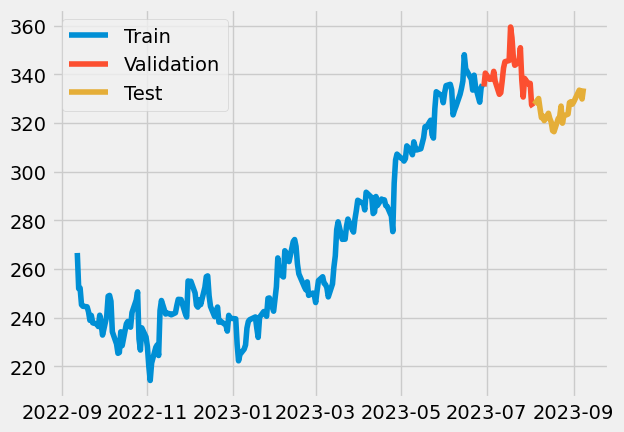

In [9]:
q_80 = int(len(dates)*0.8)
q_90 = int(len(dates)*0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] 
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] 
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] 

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### The data is split into 3 datasets . Training set takes 80% of the data, validation set takes 10% of the data, and test set takes 10% of the data. A graph is printed out for visualization purpose.

### Training the LSTM Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), 
                    layers.LSTM(64), 
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])


model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 151ms/step - loss: 72204.6328 - mean_absolute_error: 266.5285 - val_loss: 115295.2422 - val_mean_absolute_error: 339.4624
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 71933.7266 - mean_absolute_error: 266.0219 - val_loss: 115002.9297 - val_mean_absolute_error: 339.0316
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 71687.7188 - mean_absolute_error: 265.5579 - val_loss: 114674.9688 - val_mean_absolute_error: 338.5475
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 71425.8984 - mean_absolute_error: 265.0642 - val_loss: 114325.2734 - val_mean_absolute_error: 338.0306
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 71118.9531 - mean_absolute_error: 264.4826 - val_loss: 113831.6719 - val_mean_absolute_error: 337.2998
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 70620.5469 - mean_absolute_error: 263.5404 - val_los

### The codes here actually train the LSTM model. 5 layers are added to this model. The number 3 in layers.Input((3, 1)) means the data from the past 3 days is used and the number 1 means only one feature is needed (univariate forecasting). The number in other layers indicate the number of neurons for this model. Last but not the least, learning_rate and epochs can always be playing around, where learning rate controls the pace an algorithm updates and epochs means the number one complete pass of the training dataset through the algorithm.

## Making Prediciton and showing Results

7/7 [==============================] - 0s 3ms/step


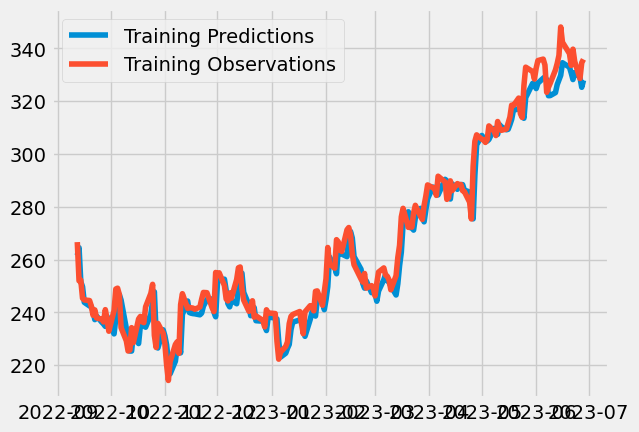

In [12]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])



1/1 [==============================] - 0s 38ms/step


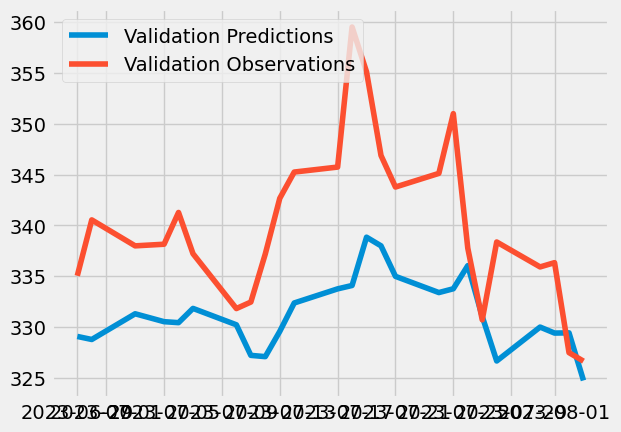

In [13]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])



1/1 [==============================] - 0s 31ms/step


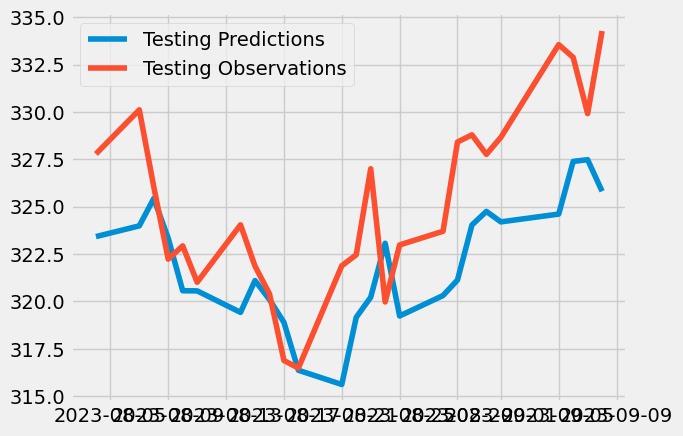

In [14]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])



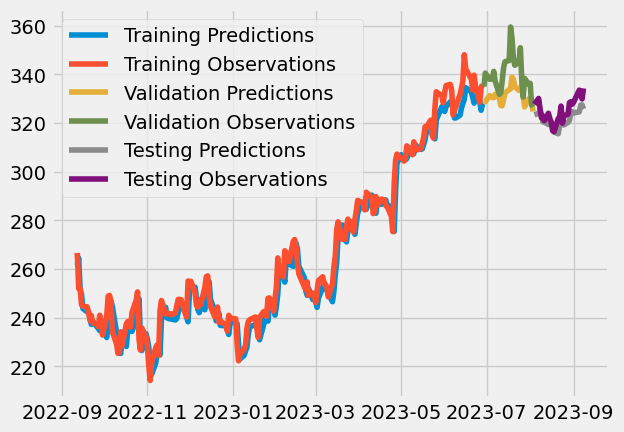

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

### This is  LSTM model is used to make the predictions based on the training set, validation set and testing set data